# BGS SV:  Spectral QA

Retrieve the spectral S/N in each arm (median, mean) for a given set of targets
and launch the spectral viewer for validating redrock results with non-zero 
warning flags.

Finally, retrieve the raw spectra to facilitate an alternative S/N definition. E.g.,
in lieu of https://github.com/desihub/desispec/issues/781 being implemented. 

In [1]:
import os
import importlib
import numpy as np
import astropy.io.fits            as fits
import pylab                      as pl

from   argparse                   import Namespace
from   astropy.table              import Table, join, Column, vstack, hstack
from   desitarget.targetmask      import (desi_mask, mws_mask, bgs_mask)
from   desispec.io.meta           import findfile

In [3]:
##  Set up some base directories with appropriate output.
##  E.g.  '/global/cscratch1/sd/mjwilson/minitest-19.2/spectro/redux/mini/exposures/20200317/00000018'

basedir      = '/global/cscratch1/sd/mjwilson/minitest-19.2/'
targetdir    = '/global/cscratch1/sd/mjwilson/minitest-19.2/targets/'
reduxdir     = '/global/cscratch1/sd/mjwilson/minitest-19.2/spectro/redux/mini/'
expfile      = '/global/cscratch1/sd/mjwilson/minitest-19.2/survey/exposures.fits'
fibassigndir = '/global/cscratch1/sd/mjwilson/minitest-19.2/fiberassign/'

##  Set spectro. output.
os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
os.environ['DESI_SPECTRO_SIM']   = os.path.join(basedir, 'spectro', 'sim')

os.environ['PIXPROD']            = 'mini'
os.environ['SPECPROD']           = 'mini'

os.environ['DESI_SPECTRO_DATA']  = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])


##  TO DO:  Set redrock template dir. etc ...

##  Explicit.
print(os.environ['DESI_SPECTRO_REDUX'])
print(os.environ['DESI_SPECTRO_SIM'])
print(os.environ['DESI_SPECTRO_DATA'])

/global/cscratch1/sd/mjwilson/minitest-19.2/spectro/redux
/global/cscratch1/sd/mjwilson/minitest-19.2/spectro/sim
/global/cscratch1/sd/mjwilson/minitest-19.2/spectro/sim/mini


In [4]:
##  Get the exposure list.
exposures = fits.open(expfile)
exposures[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  103 / length of dimension 1                          
NAXIS2  =                   45 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   18 / number of table fields                         
TTYPE1  = 'EXPID   '                                                            
TFORM1  = 'J       '                                                            
TNULL1  =               999999                                                  
TTYPE2  = 'MJD     '                                                            
TFORM2  = 'D       '        

In [11]:
##  Exposure IDs.
expids = exposures[1].data['EXPID']
expids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], dtype=int32)

In [9]:
##  Nights for which data was taken.
nights = exposures[1].data['NIGHT']
nights

chararray(['20200315', '20200315', '20200315', '20200315', '20200315',
           '20200315', '20200315', '20200315', '20200315', '20200315',
           '20200315', '20200315', '20200317', '20200317', '20200317',
           '20200317', '20200317', '20200317', '20200317', '20200317',
           '20200317', '20200317', '20200319', '20200319', '20200319',
           '20200319', '20200319', '20200319', '20200319', '20200319',
           '20200319', '20200319', '20200319', '20200411', '20200411',
           '20200411', '20200411', '20200411', '20200411', '20200411',
           '20200411', '20200411', '20200411', '20200411', '20200411'],
          dtype='<U8')

In [10]:
# -1 are calibration tiles, e.g. arcs, flats, for which dome is closed.
tileids = exposures[1].data['TILEID']
tileids

array([   -1,    -1,    -1,    -1,    -1,    -1,  1165,  1165, 24227,
       24227, 28408, 28408,    -1,    -1,    -1,    -1,    -1,    -1,
       11108, 11108,  6927,  6927,    -1,    -1,    -1,    -1,    -1,
          -1, 18465, 18465, 18465, 16870, 16870,    -1,    -1,    -1,
          -1,    -1,    -1, 34170, 34170, 45704, 45704, 39942, 39942], dtype=int32)

In [13]:
##  Each exposure length, seconds.
exptimes = exposures[1].data['EXPTIME']
exptimes

array([   10.,    10.,    10.,    10.,    10.,    10.,  1080.,   520.,
         590.,   790.,   620.,   940.,    10.,    10.,    10.,    10.,
          10.,    10.,   880.,   650.,   670.,   540.,    10.,    10.,
          10.,    10.,    10.,    10.,   480.,   810.,   760.,   670.,
         980.,    10.,    10.,    10.,    10.,    10.,    10.,   360.,
         260.,   380.,   280.,   300.,   410.], dtype=float32)

In [14]:
##  Targets file.
targets = fits.open(targetdir + '/mtl.fits')
targets[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  437 / length of dimension 1                          
NAXIS2  =               239404 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   95 / number of table fields                         
TTYPE1  = 'RELEASE '                                                            
TFORM1  = 'J       '                                                            
TTYPE2  = 'BRICKID '                                                            
TFORM2  = 'J       '                                                            
TTYPE3  = 'BRICKNAME'       

In [15]:
# Match target table to fiberassign table (tile id, fiber, etc..) by targetid.
targets[1].data['TARGETID'] = targets[1].data['targetid']

In [16]:
# Find the attributes of the first non-calibration tile.
is_nctile = tileids > -1

nctile  = tileids[is_nctile][0]
ncexp   = expids[is_nctile][0]
ncnight = nights[is_nctile][0]
nctime  = exptimes[is_nctile][0]

print(nctile, ncexp, ncnight, nctime)

1165 6 20200315 1080.0


In [18]:
##  Get the fiber assign output for this first non-calibration tile.
tpath    = fibassigndir + 'tile-{:05d}.fits'.format(nctile)
fao_tile = fits.open(tpath)

fpath    = fibassigndir + 'fiberassign_{:05d}.fits'.format(nctile)
fao_fib  = fits.open(fpath)

In [19]:
# Get the fiber map for this exposure, i.e. the spectrograph id (0-9) for each fiber in the exposure.  
# Note: the mapping is currently trivial % 500 of fiberid, but will not be in the future. 
fmap     = fits.open(findfile('fibermap', night=ncnight, expid=ncexp))
specids  = Table(fmap[1].data)
fmap.close()

In [20]:
# Construct the necessary joint table and sort by fiberid. 
ntable   = join(Table(fao_fib['FASSIGN'].data)['FIBER', 'TARGETID'], Table(targets[1].data)['RA', 'DEC', 'TARGETID', 'HPXPIXEL'], keys='TARGETID')
ntable   = join(ntable, specids['TARGETID', 'SPECTROID'], keys='TARGETID')
ntable.sort('FIBER')
ntable

FIBER,TARGETID,RA,DEC,HPXPIXEL,SPECTROID
int32,int64,float64,float64,int64,int32
5,288230398410884638,150.617752075,33.1274032593,5307,0
6,288230398410886139,150.625640869,33.0701293945,5307,0
7,288230398410885140,150.800811768,33.2164077759,5307,0
8,288230398402498265,150.860275269,33.1895866394,5305,0
9,288230398410887968,150.571438113,33.0063968297,5307,0
10,288230398410887574,150.616134644,33.0336380005,5307,0
11,288230398410886069,150.676391602,33.1563529968,5307,0
14,288230398410887758,150.743151976,33.1681794366,5307,0
16,288230398402499431,150.822753906,33.0338134766,5305,0


#### Ok, we have enough info. now (night, exposure id, nside, camera - e.g. r9) to retrieve the (calibrated) spectra for each target and corresponding S/N scores.

In [21]:
##  https://github.com/desihub/desispec/blob/master/py/desispec/specscore.py
scores = Table()

for i in range(0, 10, 1):
  _scores = Table()
    
  for camera in ['b', 'r', 'z']:
    cframe_path = findfile('cframe', night=ncnight, expid=ncexp, nside=64, camera='{}{}'.format(camera, i))
    dat         = fits.open(cframe_path)

    _scores     = hstack([_scores, Table(dat['SCORES'].data)], join_type='outer')
    
    
  _scores.add_column(Column(dat['FIBERMAP'].data['TARGETID'], name='TARGETID'), index=0)

  scores      = vstack([scores, _scores])

In [22]:
scores.sort('TARGETID')

In [23]:
scores

TARGETID,SUM_RAW_COUNT_B,MEDIAN_RAW_COUNT_B,MEDIAN_RAW_SNR_B,SUM_FFLAT_COUNT_B,MEDIAN_FFLAT_COUNT_B,MEDIAN_FFLAT_SNR_B,SUM_SKYSUB_COUNT_B,MEDIAN_SKYSUB_COUNT_B,MEDIAN_SKYSUB_SNR_B,SUM_CALIB_COUNT_B,MEDIAN_CALIB_COUNT_B,MEDIAN_CALIB_SNR_B,SUM_RAW_COUNT_R,MEDIAN_RAW_COUNT_R,MEDIAN_RAW_SNR_R,SUM_FFLAT_COUNT_R,MEDIAN_FFLAT_COUNT_R,MEDIAN_FFLAT_SNR_R,SUM_SKYSUB_COUNT_R,MEDIAN_SKYSUB_COUNT_R,MEDIAN_SKYSUB_SNR_R,SUM_CALIB_COUNT_R,MEDIAN_CALIB_COUNT_R,MEDIAN_CALIB_SNR_R,SUM_RAW_COUNT_Z,MEDIAN_RAW_COUNT_Z,MEDIAN_RAW_SNR_Z,SUM_FFLAT_COUNT_Z,MEDIAN_FFLAT_COUNT_Z,MEDIAN_FFLAT_SNR_Z,SUM_SKYSUB_COUNT_Z,MEDIAN_SKYSUB_COUNT_Z,MEDIAN_SKYSUB_SNR_Z,SUM_CALIB_COUNT_Z,MEDIAN_CALIB_COUNT_Z,MEDIAN_CALIB_SNR_Z
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-5848754,472049.204826,227.443342209,11.4703771065,463885.100441,223.481405909,11.4613815383,-671.512367348,-1.23116727526,-0.0626845047375,-23.4157475831,-0.0373042745167,-0.0626845045898,797102.384178,305.613155365,14.4611385589,783525.623589,300.452870655,14.4187505601,-78.3429447919,-0.947729780511,-0.0421630506252,-2.59721677494,-0.0152628287989,-0.042163050624,2412342.95306,346.288738251,15.6130923162,2369742.46694,340.386776199,15.5893153732,344.169630074,0.934711105761,0.040046445703,1.44313359897,0.0130845859165,0.0400464457025
-5848304,484440.085083,236.78689003,11.7109127649,464247.045879,226.361877341,11.7001323788,-309.566929289,0.13031924463,0.00727404623062,-19.6195361597,0.00538197569178,0.0072740462305,817633.335443,313.919382095,14.7121911629,783132.202557,300.636204034,14.6681275864,-471.763976661,-0.146597774714,-0.00756249195206,-5.36501282503,-0.00273388742515,-0.00756249195202,2473525.33554,359.010028839,15.8944520101,2370100.31949,344.096282717,15.8657852985,702.022182877,-0.724003000442,-0.0341378215808,13.6322558865,-0.0102832004914,-0.0341378215805
-5848303,489488.297096,237.792005539,11.7911455375,464191.520334,225.682453858,11.7808892236,-365.092473755,-0.256571484256,-0.0124501653842,-15.2730983633,-0.00944422294221,-0.0124501653841,826535.01432,317.34667778,14.7767568684,783652.821159,301.03078953,14.7351717473,48.8546251698,-1.2167885804,-0.0537696082259,-7.06472159426,-0.0201043853187,-0.0537696082235,2498846.39028,362.539310455,15.9568225402,2368890.70985,344.098511173,15.9265148056,-507.587452051,-0.587862821056,-0.0254876518771,-10.7935146254,-0.0085103893789,-0.0254876518741
-5848302,484692.03035,234.255752563,11.6502592506,464148.319033,224.256286893,11.6414194367,-408.293775035,-0.410970506938,-0.0202191608269,-5.14014426738,-0.0118239161768,-0.0202191608265,818896.256424,315.643854141,14.705821387,784314.112782,302.024385397,14.6600864675,710.146248741,0.106887436101,0.00624805684761,9.39516834568,0.00186202160227,0.00624805684754,2470793.29071,358.1864357,15.9000542832,2366315.67394,342.805091665,15.8692394316,-3082.62336627,-1.02895367714,-0.0411918224345,-36.2012659056,-0.0130868296587,-0.0411918224337
-5848301,492225.775486,237.325391769,11.7735524358,464534.685865,224.155715152,11.7639994338,-21.9269430553,-1.19967421996,-0.0617226714026,3.2361855351,-0.0336684985374,-0.0617226713938,828920.063812,317.048921585,14.7446276748,782343.827738,299.486579824,14.6970552186,-1260.13879557,-0.768988972209,-0.0336916691171,-22.7881048963,-0.0131349023747,-0.0336916691165,2507372.47768,361.377811432,15.9594138264,2366615.39246,340.742424273,15.9359658213,-2782.90484639,-1.32572821238,-0.0571743892123,-27.1009052847,-0.0184453287304,-0.0571743892081
-5848300,489319.737923,235.803899765,11.7078911603,464044.073222,223.602757998,11.6976290028,-512.5395867,-0.0647574131083,-0.00338235084253,-10.1853731165,-0.0014925808969,-0.00338235084252,825221.236763,316.992273331,14.7515584195,782532.604632,300.440005472,14.7042790111,-107

In [24]:
#  Join to the results table
ntable = join(ntable, scores, keys='TARGETID')

In [25]:
ntable.sort('FIBER')

In [27]:
#  First non-calibration exposure:  fiberid, corresponding target id and S/N values, e.g. MEDIAN_CALIB_SNR_R.
ntable

FIBER,TARGETID,RA,DEC,HPXPIXEL,SPECTROID,SUM_RAW_COUNT_B,MEDIAN_RAW_COUNT_B,MEDIAN_RAW_SNR_B,SUM_FFLAT_COUNT_B,MEDIAN_FFLAT_COUNT_B,MEDIAN_FFLAT_SNR_B,SUM_SKYSUB_COUNT_B,MEDIAN_SKYSUB_COUNT_B,MEDIAN_SKYSUB_SNR_B,SUM_CALIB_COUNT_B,MEDIAN_CALIB_COUNT_B,MEDIAN_CALIB_SNR_B,SUM_RAW_COUNT_R,MEDIAN_RAW_COUNT_R,MEDIAN_RAW_SNR_R,SUM_FFLAT_COUNT_R,MEDIAN_FFLAT_COUNT_R,MEDIAN_FFLAT_SNR_R,SUM_SKYSUB_COUNT_R,MEDIAN_SKYSUB_COUNT_R,MEDIAN_SKYSUB_SNR_R,SUM_CALIB_COUNT_R,MEDIAN_CALIB_COUNT_R,MEDIAN_CALIB_SNR_R,SUM_RAW_COUNT_Z,MEDIAN_RAW_COUNT_Z,MEDIAN_RAW_SNR_Z,SUM_FFLAT_COUNT_Z,MEDIAN_FFLAT_COUNT_Z,MEDIAN_FFLAT_SNR_Z,SUM_SKYSUB_COUNT_Z,MEDIAN_SKYSUB_COUNT_Z,MEDIAN_SKYSUB_SNR_Z,SUM_CALIB_COUNT_Z,MEDIAN_CALIB_COUNT_Z,MEDIAN_CALIB_SNR_Z
int32,int64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5,288230398410884638,150.617752075,33.1274032593,5307,0,497508.217766,240.494356155,11.8492093006,472863.206281,228.923263937,11.8382171372,8306.59347314,4.65654174534,0.228687888517,247.701541448,0.128120032624,0.228687887943,835726.654739,322.22202301,14.8598594662,794263.40002,306.264659432,14.8178841152,10659.4334862,5.17346630306,0.235144905137,189.112250468,0.0895856219973,0.235144904267,2516396.18094,373.045425415,16.2482977432,2391756.17029,354.305689766,16.2193517862,22357.8729857,10.686323877,0.436470866105,286.866248708,0.13417988364,0.436470864747
6,288230398410886139,150.625640869,33.0701293945,5307,0,533677.293854,271.224679947,12.7566826248,509140.698081,258.748263313,12.7426576567,44584.0852728,24.2387016903,1.19553754933,1193.85344396,0.70213066076,1.19553748925,1054020.31219,457.55027771,18.0324337921,1005834.51455,436.627447846,17.9484206935,222230.54802,125.252727928,4.86142019963,3696.32563432,2.13114647546,4.86141826577,2980489.55358,603.882217407,21.1600504498,2843974.08809,575.609780506,21.1004248245,474575.790781,220.36864829,7.45933052984,5852.52825062,2.66134816498,7.45932698211
7,288230398410885140,150.800811768,33.2164077759,5307,0,507423.68277,249.00683403,12.0987227747,477314.916178,234.503134065,12.0879378085,12758.3033695,7.48306370671,0.377413506386,378.400606847,0.215018475912,0.377413504145,853463.794899,332.605113983,15.132044373,803139.70149,312.972459894,15.0846404255,19535.7349564,9.45902284651,0.422118484324,331.120250409,0.164458439869,0.422118481615,2546899.59472,382.005825043,16.4937687656,2396953.94524,360.283833979,16.4603092216,27555.6479361,12.8691293745,0.527947068786,336.222579553,0.16177562031,0.527947066414
8,288230398402498265,150.860275269,33.1895866394,5305,0,583463.198219,296.410350799,13.3896055609,551856.980546,280.511103715,13.3753808301,87300.3677377,40.2574957533,1.96490534897,2455.114374,1.21584292591,1.96490493233,948926.734167,383.516788483,16.4417020363,897864.997645,362.608186293,16.3805609488,114261.031112,61.3367701709,2.63148377672,1953.63410903,1.04235181213,2.63148350062,2629902.10196,427.423992157,17.5676924175,2487924.00594,404.318028253,17.5346536237,118525.708636,53.1456677548,2.07974064891,1473.68883022,0.663163925483,2.07974056486
9,288230398410887968,150.571438113,33.0063968297,5307,0,496409.604321,244.698543549,11.9938333735,476954.418227,235.243690735,11.9822498982,12397.8054187,7.63435653678,0.382449748519,359.003732485,0.225077960818,0.382449744576,849321.668964,331.244163513,15.1110220974,816183.647023,317.981270985,15.0672726455,32579.6804898,16.0948245152,0.737250733908,541.768278631,0.287937660637,0.737250729047,2531321.75236,388.682498932,16.6089164995,2432489.78777,373.793644038,16.5770818557,63091.490461,28.5027449799,1.12407674201,782.954280119,0.358504633648,1.12407668311
10,288230398410887574,150.616134644,33.0336380005,5307,0,562895.653809,282.666606903,13.1084241177,538953.324299,270.603876099,13.09

#### Now, we want to contrast these S/N measures with the redrock output. 
E.g. is there a correlation of raw S/N with zwarn.  For this, we'll append 
the redrock output based, again, on targetid. 

In [28]:
zcatalog = Table(fits.open(findfile('zcatalog'))[1].data)
zcatalog

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,DEC,RA_IVAR,DEC_IVAR,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB,EBV,PHOTSYS,DESI_TARGET,BGS_TARGET,MWS_TARGET,PRIORITY_INIT,SUBPRIORITY,NUMOBS_INIT,HPXPIXEL
int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32,int32,int32,str8,int32,str4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bool,float32,str1,int64,int64,int64,int64,float64,int64,int64
288230398217946081,8841.62489197,348.150234539 .. 2.08758365674,0.0810812838573,2.68658980895e-05,0,8591,GALAXY,,10,191.914015526,2,1,9999,492449,1526p292,993,REX,152.603149414,29.2433719635,1e+08,1e+08,12.5931,21.0427,29.7519,22.0967,14.529,1438.6,329.564,62.7972,0.757669,0.300346,0.936643,0.956868,0.975441,0.99626,0.997701,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.31708,41351.8,0.0,0.0,0.0,0.0,2.25125,3.86936,5.65025,2.25125,3.86936,5.65025,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,1.0,0.0,1.0,0.0,1.0,False,0.0221111,S,1152921504606846976,2,0,2100,0.954556089846,1,5261
288230398217946094,8197.99244484,189.19509711 .. -5.43589751597,0.37152230544,0.000416991905706,0,8591,GALAXY,,10,41.7378459547,2,1,9999,491188,1524p290,1006,REX,152.578598022,29.0948295593,1e+08,1e+08,3.57246,16.1324,37.329,56.3802,39.6329,1438.6,329.564,62.7972,0.757102,0.300128,0.940531,0.959542,0.976977,0.996496,0.997847,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.24729,26104.1,0.0,0.0,0.0,0.0,0.681806,3.1702,7.58481,0.681806,3.1702,7.58481,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,1.0,0.0,1.0,0.0,1.0,False,0.0207115,S,1152921504606846976,2,0,2100,0.493593198558,1,5261
288230398217946095,8490.32520854,237.433445186 .. 7.11818250805,0.156976855827,0.000472996296241,0,8591,GALAXY,,10,32.5371312671,2,1,9999,492449,1526p292,1007,DEV,152.62361145,29.167842865,1e+08,1e+08,7.12094,18.9062,35.4696,40.1526,31.8595,1438.6,329.564,62.7972,0.757421,0.300251,0.93786,0.957705,0.975922,0.996334,0.997747,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,1.0,0.0,0.989599,100664.0,0.277077,2.84404e+16,0.0926993,78465.5,0.0,0.0,0.0,0.0,0.0,0.0,1.91392,5.31222,10.4768,1.91392,5.31222,10.4768,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,1.0,0.0,1.0,0.0,1.0,False,0.0216723,S,11529215046068

In [29]:
ntable = join(ntable, zcatalog['TARGETID', 'Z', 'ZERR', 'ZWARN', 'CHI2', 'NUMEXP'], keys='TARGETID')

In [30]:
ntable.sort('FIBER')

In [32]:
##  Sufficient table for the S/N tests.
ntable

FIBER,TARGETID,RA,DEC,HPXPIXEL,SPECTROID,SUM_RAW_COUNT_B,MEDIAN_RAW_COUNT_B,MEDIAN_RAW_SNR_B,SUM_FFLAT_COUNT_B,MEDIAN_FFLAT_COUNT_B,MEDIAN_FFLAT_SNR_B,SUM_SKYSUB_COUNT_B,MEDIAN_SKYSUB_COUNT_B,MEDIAN_SKYSUB_SNR_B,SUM_CALIB_COUNT_B,MEDIAN_CALIB_COUNT_B,MEDIAN_CALIB_SNR_B,SUM_RAW_COUNT_R,MEDIAN_RAW_COUNT_R,MEDIAN_RAW_SNR_R,SUM_FFLAT_COUNT_R,MEDIAN_FFLAT_COUNT_R,MEDIAN_FFLAT_SNR_R,SUM_SKYSUB_COUNT_R,MEDIAN_SKYSUB_COUNT_R,MEDIAN_SKYSUB_SNR_R,SUM_CALIB_COUNT_R,MEDIAN_CALIB_COUNT_R,MEDIAN_CALIB_SNR_R,SUM_RAW_COUNT_Z,MEDIAN_RAW_COUNT_Z,MEDIAN_RAW_SNR_Z,SUM_FFLAT_COUNT_Z,MEDIAN_FFLAT_COUNT_Z,MEDIAN_FFLAT_SNR_Z,SUM_SKYSUB_COUNT_Z,MEDIAN_SKYSUB_COUNT_Z,MEDIAN_SKYSUB_SNR_Z,SUM_CALIB_COUNT_Z,MEDIAN_CALIB_COUNT_Z,MEDIAN_CALIB_SNR_Z,Z,ZERR,ZWARN,CHI2,NUMEXP
int32,int64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int32
5,288230398410884638,150.617752075,33.1274032593,5307,0,497508.217766,240.494356155,11.8492093006,472863.206281,228.923263937,11.8382171372,8306.59347314,4.65654174534,0.228687888517,247.701541448,0.128120032624,0.228687887943,835726.654739,322.22202301,14.8598594662,794263.40002,306.264659432,14.8178841152,10659.4334862,5.17346630306,0.235144905137,189.112250468,0.0895856219973,0.235144904267,2516396.18094,373.045425415,16.2482977432,2391756.17029,354.305689766,16.2193517862,22357.8729857,10.686323877,0.436470866105,286.866248708,0.13417988364,0.436470864747,0.976617163699,8.55888428143e-05,4,8446.23696402,2
6,288230398410886139,150.625640869,33.0701293945,5307,0,533677.293854,271.224679947,12.7566826248,509140.698081,258.748263313,12.7426576567,44584.0852728,24.2387016903,1.19553754933,1193.85344396,0.70213066076,1.19553748925,1054020.31219,457.55027771,18.0324337921,1005834.51455,436.627447846,17.9484206935,222230.54802,125.252727928,4.86142019963,3696.32563432,2.13114647546,4.86141826577,2980489.55358,603.882217407,21.1600504498,2843974.08809,575.609780506,21.1004248245,474575.790781,220.36864829,7.45933052984,5852.52825062,2.66134816498,7.45932698211,0.54962435128,7.30783341864e-05,0,8546.92518596,2
7,288230398410885140,150.800811768,33.2164077759,5307,0,507423.68277,249.00683403,12.0987227747,477314.916178,234.503134065,12.0879378085,12758.3033695,7.48306370671,0.377413506386,378.400606847,0.215018475912,0.377413504145,853463.794899,332.605113983,15.132044373,803139.70149,312.972459894,15.0846404255,19535.7349564,9.45902284651,0.422118484324,331.120250409,0.164458439869,0.422118481615,2546899.59472,382.005825043,16.4937687656,2396953.94524,360.283833979,16.4603092216,27555.6479361,12.8691293745,0.527947068786,336.222579553,0.16177562031,0.527947066414,1.35072736172,0.000196725096012,0,8456.877041,2
8,288230398402498265,150.860275269,33.1895866394,5305,0,583463.198219,296.410350799,13.3896055609,551856.980546,280.511103715,13.3753808301,87300.3677377,40.2574957533,1.96490534897,2455.114374,1.21584292591,1.96490493233,948926.734167,383.516788483,16.4417020363,897864.997645,362.608186293,16.3805609488,114261.031112,61.3367701709,2.63148377672,1953.63410903,1.04235181213,2.63148350062,2629902.10196,427.423992157,17.5676924175,2487924.00594,404.318028253,17.5346536237,118525.708636,53.1456677548,2.07974064891,1473.68883022,0.663163925483,2.07974056486,3.27193927442,0.000121043174946,0,14551.1674962,7
9,288230398410887968,150.571438113,33.0063968297,5307,0,496409.604321,244.698543549,11.9938333735,476954.418227,235.243690735,11.9822498982,12397.8054187,7.63435653678,0.382449748519,359.003732485,0.225077960818,0.382449744576,849321.668964,331.244163513,15.1110220974,816183.647023,317.981270985,15.0672726455,32579.6804898,16.0948245152,0.737250733908,541.768278631,0.287937660637,0.737250729047,2531321.75236,388.682498932,16.608916499

In [36]:
##  First, sort by HPXPIXEL.
ntable.sort('HPXPIXEL')

##  E.g. those with a non-zero warning.
##  Note these are defined here: https://github.com/desihub/redrock/blob/master/py/redrock/zwarning.py
ntable[ntable['ZWARN'] == 4]

FIBER,TARGETID,RA,DEC,HPXPIXEL,SPECTROID,SUM_RAW_COUNT_B,MEDIAN_RAW_COUNT_B,MEDIAN_RAW_SNR_B,SUM_FFLAT_COUNT_B,MEDIAN_FFLAT_COUNT_B,MEDIAN_FFLAT_SNR_B,SUM_SKYSUB_COUNT_B,MEDIAN_SKYSUB_COUNT_B,MEDIAN_SKYSUB_SNR_B,SUM_CALIB_COUNT_B,MEDIAN_CALIB_COUNT_B,MEDIAN_CALIB_SNR_B,SUM_RAW_COUNT_R,MEDIAN_RAW_COUNT_R,MEDIAN_RAW_SNR_R,SUM_FFLAT_COUNT_R,MEDIAN_FFLAT_COUNT_R,MEDIAN_FFLAT_SNR_R,SUM_SKYSUB_COUNT_R,MEDIAN_SKYSUB_COUNT_R,MEDIAN_SKYSUB_SNR_R,SUM_CALIB_COUNT_R,MEDIAN_CALIB_COUNT_R,MEDIAN_CALIB_SNR_R,SUM_RAW_COUNT_Z,MEDIAN_RAW_COUNT_Z,MEDIAN_RAW_SNR_Z,SUM_FFLAT_COUNT_Z,MEDIAN_FFLAT_COUNT_Z,MEDIAN_FFLAT_SNR_Z,SUM_SKYSUB_COUNT_Z,MEDIAN_SKYSUB_COUNT_Z,MEDIAN_SKYSUB_SNR_Z,SUM_CALIB_COUNT_Z,MEDIAN_CALIB_COUNT_Z,MEDIAN_CALIB_SNR_Z,Z,ZERR,ZWARN,CHI2,NUMEXP
int32,int64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int32
4554,288230398377332059,151.787902832,32.6387710571,5299,9,445091.530693,215.305223465,11.0669268675,476775.603667,230.913721088,11.0557838579,12093.9286865,6.34040320745,0.295484995898,371.687733399,0.197676268286,0.295484995299,744256.525719,288.753786087,13.9252541111,797332.370014,309.044724954,13.8772408342,13335.2162011,7.43422010236,0.321294371182,226.698880438,0.12866905215,0.321294370943,2239396.55072,333.776111603,15.2984436694,2398954.3897,358.215794393,15.2672306615,29654.696675,12.8013282772,0.478990703538,371.09651977,0.159456356231,0.478990702689,0.190961499137,8.03099676107e-05,4,8606.84523038,2
4569,288230398377331740,151.829910278,32.6351623535,5299,9,445652.869778,218.41711998,11.1483115476,478360.002078,234.425677895,11.1394356828,13678.3270977,7.95698034028,0.382596252029,422.942395854,0.240972287952,0.382596248304,743362.890842,289.364719391,14.0053084285,797757.751559,310.397739716,13.958746411,13760.5977464,7.82973609165,0.333957415432,241.584321476,0.133530846837,0.333957415147,2227260.5119,329.723548889,15.1852635588,2390268.58164,353.432572833,15.1553853173,20968.8886157,8.83547458968,0.341006304568,262.819062511,0.112158664757,0.341006304068,0.699337446922,0.000124470823001,4,8622.72573317,2
4348,288230398389914261,152.404159546,33.2546463013,5302,8,444725.607563,218.18274498,11.1318934923,477244.61959,234.186012382,11.122757604,12743.1303707,6.47525820371,0.306088265458,381.100332229,0.188686438416,0.306088264663,746290.916864,287.788896561,13.9488984806,800937.19926,308.696578892,13.9114740057,17571.5941042,9.58629567108,0.402856196725,305.207836705,0.166672401303,0.402856195963,2235000.99156,336.185035705,15.2863563187,2399046.29799,361.029112871,15.2596584928,30279.1604461,13.5410478722,0.509575396041,372.759593625,0.167628871915,0.509575395298,1.10701254463,0.000168313735116,4,8492.22167829,2
4313,288230398389914570,152.398651123,33.2243156433,5302,8,439120.783321,214.247131348,11.0054317287,474425.284466,231.21420666,10.9953952819,9923.79524594,4.80432110279,0.231610681545,291.1325597,0.156862835911,0.23161068055,739766.732069,288.112649918,13.9797795704,799035.170724,311.484056495,13.9304985513,15669.5655682,8.16880438351,0.344981491248,257.775544796,0.141649492374,0.344981490754,2207242.25678,327.425994873,15.1322737125,2384928.09978,354.069648389,15.1064991429,16160.9622423,7.57106305767,0.296612689284,198.088897556,0.0989466837831,0.296612688988,0.661974273183,7.8414272293e-05,4,8541.54419768,2
4349,288230398389916438,152.463539216,33.2847001159,5302,8,438511.072243,213.2168293,10.9856646839,474877.157683,231.173747492,10.9744154918,10375.6684637,5.88922698002,0.277913607954,304.36726722,0.170755007757,0.27791360717,735639.281183,286.015377045,13.8949661134,796748.830718,310.518495077,13.8618855197,13383.2255622,7.55756854088,0.32634430708,228.252154891,0.129591942164,0.326344305816,2211421.585

In [34]:
##  Define the relevant target ids. 
dudids = [str(int(x)) for x in ntable[ntable['ZWARN'] == 4]['TARGETID'].quantity]

#### Launch the spectral viewer for these flagged objects.
Left / right for redrock fits & up / down for targets.  It'd be alot easier to 'gather' on HPXPIXEL
before inputing to rrplot?

In [ ]:
##  ntable['SPECTRA_GROUPNAME'][0]
rr_path   = findfile('redrock', night=ncnight, expid=ncexp, nside=64, groupname=int(ntable['HPXPIXEL'][0]))
spec_path = findfile('spectra', night=ncnight, expid=ncexp, nside=64, groupname=int(ntable['HPXPIXEL'][0]))

In [ ]:
##  --allspec: coadd or not?
cmd  = 'rrplot --datatype desi --specfile {}'.format(spec_path)
cmd += '  --rrfile {}'.format(rr_path)
cmd += '  --targetids ' + ','.join(dudids[0:10])
cmd

In [37]:
##  To be launched in the terminal (interactive matplotlib).

```
rrplot 
--datatype desi 
--specfile /global/cscratch1/sd/mjwilson/minitest-19.2/spectro/redux/mini/spectra-64/53/5307/spectra-64-5307.fits  
--rrfile /global/cscratch1/sd/mjwilson/minitest-19.2/spectro/redux/mini/spectra-64/53/5307/redrock-64-5307.h5
```

####  We successfully retrieved the pre-defined S/N measures for cross-referencing with the redrock results.  But what if we want to define our own?

In [38]:
##  Set up external calculation of signal-to-noise. 
from desispec.io.frame import read_frame

##  Replace with findfile.
filename = '/global/cscratch1/sd/mjwilson/minitest-19.2/spectro/redux/mini/exposures/20200411/00000044/cframe-r0-00000044.fits'
frame    = read_frame(filename, nspec=25, skip_resolution=False)

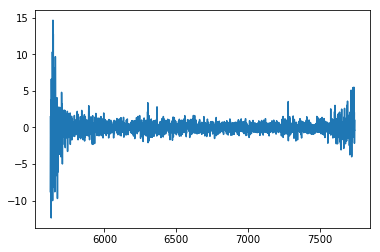

In [39]:
pl.plot(frame.wave, frame.flux[0,:])

In [41]:
from desispec.specscore import compute_frame_scores

##  See the script here for
results, comments = compute_frame_scores(frame, band='r', suffix=None)

In [42]:
comments

{'INTEG_FLUX_R': 'integ. flux in wave. range 5800,7600A',
 'MEDIAN_FLUX_R': 'median flux in wave. range 5800,7600A',
 'MEDIAN_SNR_R': 'median SNR/sqrt(A) in wave. range 5800,7600A'}

In [43]:
results

{'INTEG_FLUX_R': array([  8.75673138e+00,   1.94250642e+01,  -5.56512771e+00,
          2.80802716e-01,   8.19629114e+00,   2.67864946e+03,
          6.05077374e+03,   8.70950240e+02,   3.51316489e+03,
          1.40084312e+03,   6.17006113e+03,   1.23988674e+04,
          1.24294266e+03,   4.34158223e+03,   1.66175185e+03,
          1.53905618e+03,   6.64596779e+03,   1.03073154e+03,
          3.97199209e+03,   1.98476307e+03,   1.56049005e+03,
          8.79354065e+02,   3.19053743e+04,   2.41713216e+03,
          6.46180044e+03]),
 'MEDIAN_FLUX_R': array([  2.58985284e-03,   1.19290720e-02,   6.03675586e-03,
          2.38604308e-03,  -2.54419795e-03,   1.36550951e+00,
          3.30407989e+00,   4.65890005e-01,   1.91999894e+00,
          7.78323352e-01,   3.41204417e+00,   6.87293935e+00,
          7.12030590e-01,   2.39807403e+00,   8.85349214e-01,
          8.54871005e-01,   3.71813595e+00,   5.67966312e-01,
          2.20839691e+00,   1.07734770e+00,   8.51161063e-01,
         

#### Done.